# Predict and evaluate SkillsColBERT

In [25]:
# install
# !pip install pytorch-pretrained-bert pytorch-nlp keras scikit-learn matplotlib tensorflow
#!pip install -U sentence-transformers
#https://towardsdatascience.com/bert-for-dummies-step-by-step-tutorial-fb90890ffe03 

In [2]:
# BERT imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
from sklearn.metrics import f1_score
import io
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

UsageError: Line magic function `%` not found.


In [3]:
# specify CPU or GPU as device
if torch.cuda.is_available():
  device = 'cuda'
else:
  device = 'cpu'
print(f'device = {device}')

device = cpu


In [4]:
# Load data
df = pd.read_csv(r'.\data\skills_description.csv', sep='\t', encoding='utf-8')
df = df.rename(columns={'preferredLabel':'query', 'description': 'documents'})
df = df[['query', 'documents']]

df

,query,documents
0,lede musikalsk personale,Tildele og forvalte personaleopgaver på område...
1,føre tilsyn med fængselsprocedurer,Føre tilsyn med driften af et fængsel eller an...
2,anvende antioppressiv praksis,"Identificere undertrykkelse i samfund, økonomi..."
3,kontrollere overensstemmelse med jernbaneforsk...,"Inspicere rullende materiel, komponenter og sy..."
4,identificere tilgængelige tjenester,"Identificere de forskellige tjenester, der er ..."
...,...,...
13480,forbedre sundhedsbrugers erhvervsevne,"Forbedre eller genoprette de kognitive, sensor..."
13481,installere lys i transportudstyr,Montere lyselementer i transportudstyr i henho...
13482,taleprogsbehandling,"Teknologier, der gør IKT-udstyr i stand til at..."
13483,koordinere bygge- og anlægsaktiviteter,Koordinere flere bygningsarbejderes eller hold...


In [5]:
# Split data into training, test and validation:
# Note that it is actually only "queries" we want to split, as all documents should always be a posibility

df_train, df_test = train_test_split(df, test_size=0.1)
df_train, df_val = train_test_split(df_train, test_size=0.1)

print(f'# obs in train: {len(df_train)} \n# obs in test:  {len(df_test)} \n# obs in validation:  {len(df_val)}' )

# obs in train: 10922 
# obs in test:  1349 
# obs in validation:  1214


In summary, given a query sequence $q = q_0 q_1...q_l$ and a document sequence $d = d_0 d_1...d_n$, we compute the bags of embeddings $E_q$ and $E_d$ in the following manner:

* $E_q$ := NN( BERT(“[Q]$q_0 q_1...q_l$ ##...#”) ) 

* $E_d$ := NN( BERT(“[D]$d_0 d_1...d_l$ ...d_n”) ) 

where '#' refers to the [mask] tokens. 

In the baseline SBERT the output dimensions are as follow:
\begin{align*}
    dim(E_q) = [1 \times 768] \\
    dim(E_d) = [1 \times 768]
\end{align*}

\begin{align*}
    dim(E_Q) = [13,485 \times 768] \\
    dim(E_D) = [13,485 \times 768]
\end{align*}


but with ColBert the last dimension is reduced to 132 by an additional linear layer, such that my implementation of ColBERT, the output dimensions are as follow:
\begin{align*}
    dim(E_q) = [1 \times 132] \\
    dim(E_d) = [1 \times 132]
\end{align*}

In practice the MaxSim score is implemented such that 1 query is evaluated against all ducuments. Therefore the relevant dimensions are:
\begin{align*}
    dim(E_Q) = [13,485 \times 132] \\
    dim(E_D) = [13,485 \times 132]
\end{align*}


### The relevancy score, MaxSim, is defined as follows:
$$ S_{Q,D} =  E_{Q} * E_{D}^T$$
$$dim(S_{Q,D}) = [13,485 \times 13,485] $$

The MaxSim score rates alle combinations of queries and documents. The most similar document is 
$$\underset{j\in ||D||}{\max}  S_{Q,D} $$
$$\dim(\underset{j\in ||D||}{\max}  S_{Q,D}) = [13.485 \times 1]$$



In [6]:
def accuracy_top_k(Q, pred_idx):
    '''Return the accuracy score of correct predictions in top k'''
    yes_no = []
    for i in range(Q.shape[0]):
        yes_no.append(i in pred_idx[i])

    return np.sum(yes_no) / Q.shape[0]

## Define Model

In [7]:
from sentence_transformers import SentenceTransformer, util

SBERT = SentenceTransformer('sentence-transformers/stsb-xlm-r-multilingual')
SBERT.to(device)

SentenceTransformer(
  (0): Transformer({'max_seq_length': 128, 'do_lower_case': False}) with Transformer model: XLMRobertaModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
)

In [9]:
class Q_ColBERT(nn.Module):
      def __init__(self):
            super(Q_ColBERT, self).__init__()
            self.SBERT = SBERT 
            ### New layers:
            self.linear1 = nn.Linear(768, 132) 

            # Freeze parameters of BERT Base as I only will train last layer
            for param in SBERT.parameters():
                  param.requires_grad = False
          

      def forward(self, queries, documents , dist_measure='MaxSim'):


            query_embeddings = torch.tensor(SBERT.encode(list(queries))).to(device)
            query_embeddings = self.linear1(query_embeddings)
            #query_embeddings = F.normalize(query_embeddings, p=2.0, dim=0, eps=1e-12, out=None)
            #query_embeddings = F.softmax(query_embeddings, dim=0)

            doc_embeddings = torch.tensor(SBERT.encode(list(documents))).to(device)
            doc_embeddings = self.linear1(doc_embeddings)
            #doc_embeddings = F.normalize(doc_embeddings, p=2.0, dim=1, eps=1e-12, out=None)
            #doc_embeddings = F.softmax(doc_embeddings, dim=1)

            # Compute score for a query against all documents (in batch) 
            if dist_measure=='MaxSim':
                   sim = torch.matmul(query_embeddings, torch.t(doc_embeddings))
            
            elif dist_measure=='MinEuc': 
                  sim = EucDist = torch.cdist(query_embeddings, doc_embeddings, p=2, compute_mode='use_mm_for_euclid_dist_if_necessary')


            return F.softmax(sim, dim=1) 


Q_colbert = Q_ColBERT()


In [33]:
batch_size = 10
raw_documents = df_train['documents'].iloc[:batch_size]
raw_query = df_train['query'].iloc[:batch_size]

preds = Q_colbert(queries=raw_query, documents=raw_documents, dist_measure='MaxSim')
preds.shape

torch.Size([10, 10])

In [39]:
preds.shape
lables

#torch.divide(

#torch.max(preds, dim=0)[1]

0.7

# Train Sentence Bert XLM RoBERTa

In [16]:
# Activate / assign model
model = Q_ColBERT()
model.to(torch.device(device))
criterion = nn.CrossEntropyLoss()
#criterion = nn.MSELoss() 
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()))  # alternative: optim.SGD(model.parameters(), lr=0.01, momentum = 0.9)

In [41]:
from torch.autograd import Variable

num_epoch = 21
batch_size = 10

# Create lables (always the same)
lables = torch.arange(0, batch_size).type(torch.LongTensor)

# Initialize lists for training and validation
train_iter = []
train_loss, train_accs = [], []
valid_iter = []
valid_loss, valid_accs = [], []



for epoch in range(num_epoch):  # loop over the dataset multiple times

    train_running_loss = 0.0
    model.train()

    # load batch data
    data = df_train.sample(n=batch_size) # df_train.iloc[:batch_size]
    raw_documents = data['documents']
    raw_query = data['query']
    
    # zero the parameter gradients
    optimizer.zero_grad()       
    
    # make similarity score
    preds = Q_colbert(queries=raw_query, documents=raw_documents, dist_measure='MaxSim')
    train_accs.append(torch.sum(torch.max(preds, dim=1)[1]==lables).item() / batch_size)

    # Compute loss
    loss = criterion(preds, target=lables)
    
    # backward
    loss.backward()
    
    # optimize
    optimizer.step()
    
    # print statistics
    train_running_loss += loss.item() 
    train_iter.append(epoch)
    train_loss.append(train_running_loss/batch_size)
    

        
    ###### Validation #####
    val_running_loss = 0.0
    model.eval()
    # load batch data
    data = df_val.sample(n=batch_size) # df_val.iloc[:batch_size]
    raw_documents = data['documents']
    raw_query = data['query']

    # zero the parameter gradients
    optimizer.zero_grad()       

    # make similarity score
    preds = Q_colbert(queries=raw_query, documents=raw_documents, dist_measure='MaxSim')
    valid_accs.append(torch.sum(torch.max(preds, dim=1)[1]==lables).item() / batch_size)

    # Compute loss
    loss = criterion(preds, target=lables)

     ## backward
    loss.backward()

    # optimize
    optimizer.step()

    # print statistics
    val_running_loss += loss.item() 
    valid_iter.append(epoch)
    valid_loss.append(val_running_loss/batch_size)

    


    if epoch % 10 == 0:    # print every 1000 mini-batches
        print('epoch [%d] training loss: %.2f validation loss %.2f Train acc %.2f, Valid acc %.2f' %
              (epoch + 1, train_running_loss , val_running_loss, train_accs[-1], valid_accs[-1]))
        
        train_running_loss = 0.0
        val_running_loss = 0

Epochs = np.arange(len(train_acc))
plt.figure()
plt.plot(Epochs, train_accs, 'r', Epochs, valid_accs, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('Acc')

epoch [1] training loss: 1.77 validation loss 1.74 Train acc 0.900000, Valid acc 0.800000
epoch [11] training loss: 1.91 validation loss 1.81 Train acc 0.600000, Valid acc 0.800000


(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'Acc'))

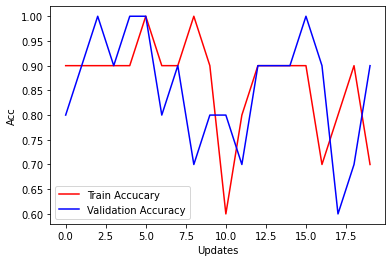

In [44]:
Epochs = np.arange(len(train_accs))
plt.figure()
plt.plot(Epochs, train_accs, 'r', Epochs, valid_accs, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('Acc')

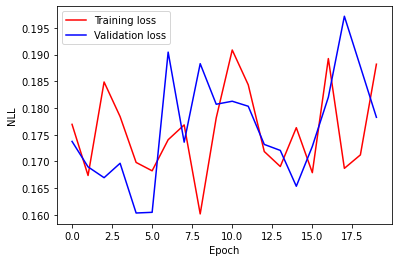

In [43]:
Epochs = np.arange(len(train_iter))
plt.figure()
plt.plot(Epochs, train_loss, 'r', label='Training loss',)
plt.plot(Epochs, valid_loss, 'b', label='Validation loss')
plt.legend()
plt.xlabel('Epoch'), plt.ylabel('NLL')
plt.show()

## MaxSim implementation

In [11]:
# Calculate MaxSim and assign most similar document ID for each query
maks, maks_idx = xlmMaxSim(Q=q_outputs, D=d_outputs)

# Create query ids (0-13,485)
most_similar_docID = maks_idx
q_IDs = [x for x in range(q_outputs.shape[0])]

# Due to the unchanged order - IDs are also the true labls
y_true = q_IDs
y_pred = most_similar_docID

# Calculate and display f1-score
print('f_1score: ', round(f1_score(y_true, y_pred, average='weighted'),4))

# Calculate correct and wrong predictions
rights = sum(np.array(y_true) == np.array(y_pred))
wrongs = sum(np.array(y_true) != np.array(y_pred))

# Calculate and display accuracy score
print(f'rights: {rights} out of {rights+wrongs} \n {np.round(rights/(rights+wrongs)*100,3)}% accuracy')


f_1score:  0.1489
rights: 2792 out of 13485 
 20.704% accuracy


In [12]:
# In top k
k=10

# Similarity calculation
mm = torch.matmul(q_outputs, torch.t(d_outputs))

# find to k most similar
maxSim, maks_idx = torch.topk(mm, k, largest=True)

top_k_acc = accuracy_top_k(Q=q_outputs, pred_idx=maks_idx)

print(f'Top {k} accuracy: {np.round(top_k_acc*100,2)}%' )

Top 10 accuracy: 50.73%


In [13]:
# Distribution of "predictions"
plt.figure(figsize=(18, 8), dpi=80)
plt.hist(most_similar_docID, bins=q_outputs.shape[0])
plt.title('Distribution of predictions of Maximum Similarity', fontsize=32)
plt.xlabel('Document ID', fontsize=28)

plt.ylabel('No. of predictions', fontsize=28)
plt.ylim(0,80)

plt.savefig(r'J:\VOA\MABI\Deep Learning\my_DTU_project\images\xlm_distribution_MaxSim.png')
plt.show()

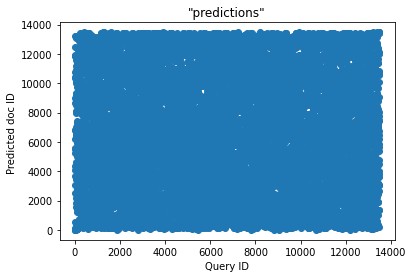

In [48]:
# Distribution of "predictions"
plt.scatter(q_IDs, most_similar_docID)
plt.title('"predictions"')
plt.xlabel('Query ID')
plt.ylabel('Predicted doc ID ')
plt.show()

In [12]:
df_correct = df.loc[(np.array(y_true) == np.array(y_pred))]
df_correct

,query,documents
12,udføre gadeinterventioner i forbindelse med so...,Gennemføre outreachaktiviteter ved at give dir...
15,udføre forskning af flora,Indsamle og analysere data om planter med henb...
18,undervise i husholdning,Undervise i såvel husholdning som manuelle fær...
28,producere guitarkomponenter,"Vælg det relevante tonetræ, materialer og værk..."
29,betjene landbrugsmaskiner,"Betjene motordrevet landbrugsudstyr, herunder ..."
...,...,...
13456,overvågningsmetoder,"Overvågningsmetoder, der anvendes til indsamli..."
13463,indsamle husholdningsaffald,Indsamle ikke-farligt affald fra beboelsesområ...
13465,typer af borebits,Egenskaber og anvendelser af forskellige typer...
13471,stofafhængighed,"Afhængighed af stoffer som alkohol, ordineret ..."


## Example of implementation of MINIMUM Eucledian distance

In [61]:
# Compute euclidean distance and store documents that are close
min_dist, min_idx = MinEuc(Q=q_outputs, D=d_outputs)

# Store in numpy array and create query ids (0-13,485)
most_similar_docID = np.array(min_idx)
q_IDs = [x for x in range(q_outputs.shape[0])]

# Due to the unchanged order - IDs are also the true labls
y_true = q_IDs
y_pred = most_similar_docID

# Calculate and display f1-score
print('f_1score: ', round(f1_score(y_true, y_pred, average='weighted'),4))

# Calculate correct and wrong predictions
rights = sum(np.array(y_true) == np.array(y_pred))
wrongs = sum(np.array(y_true) != np.array(y_pred))

# Calculate and display accuracy
print(f'rights: {rights} out of {rights+wrongs} \n {np.round(rights/(rights+wrongs)*100,2)}% accuracy')


f_1score:  0.1756
rights: 3009 out of 13485 
 22.31% accuracy


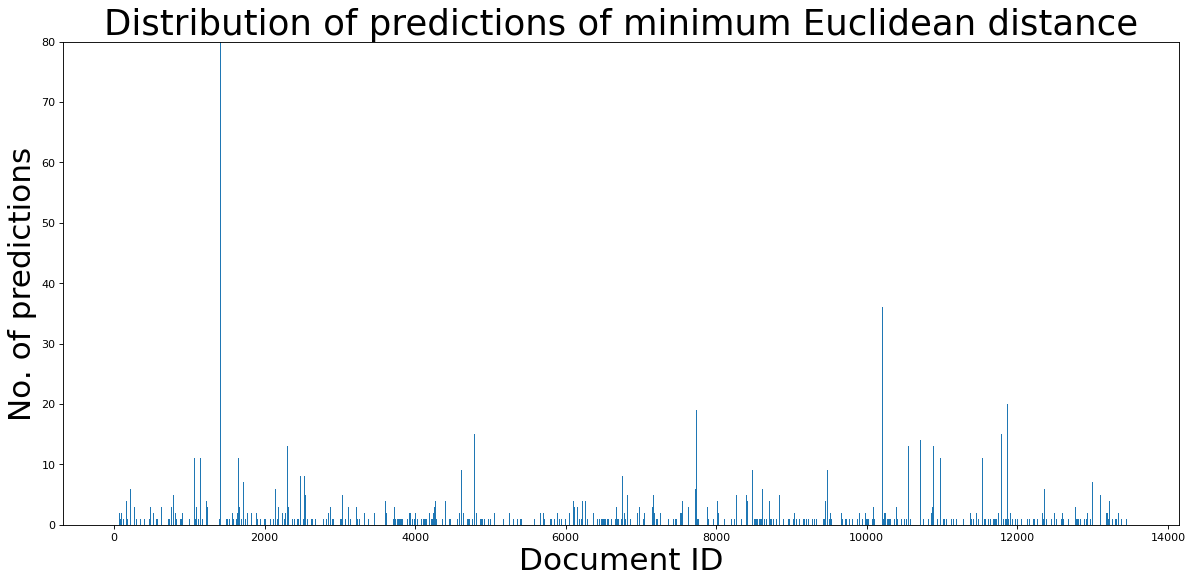

In [72]:
# Distribution of "predictions"
plt.figure(figsize=(18, 8), dpi=80)

plt.hist(most_similar_docID, bins=q_outputs.shape[0])
plt.title('Distribution of predictions of minimum Euclidean distance',  fontsize=32)
plt.xlabel('Document ID', fontsize=28)
plt.ylabel('No. of predictions', fontsize=28)
plt.ylim(0,80)

plt.savefig(r'J:\VOA\MABI\Deep Learning\my_DTU_project\images\xlm_distribution_Euclidean.png')
plt.show()

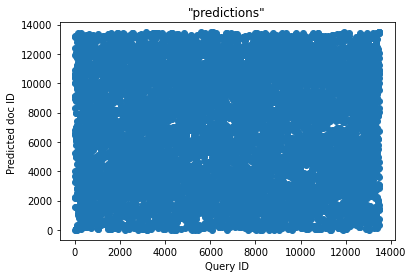

In [19]:
# Distribution of "predictions"
q_IDs = [x for x in range(q_outputs.shape[0])]
plt.scatter(q_IDs, mini_ids)
plt.title('"predictions"')
plt.xlabel('Query ID')
plt.ylabel('Predicted doc ID ')
plt.show()

In [18]:
y_true = q_IDs
y_pred = min_idx

print('f_1score: ', round(f1_score(y_true, y_pred, average='macro'),4))

rights = sum(np.array(y_true) == np.array(y_pred))
wrongs = sum(np.array(y_true) != np.array(y_pred))

print(f'rights: {rights} out of {rights+wrongs} \n {np.round(rights/(rights+wrongs),3)}% accuracy')

f_1score:  0.1756
rights: 3009 out of 13485 
 0.223% accuracy


In [58]:
# In top k
k=5
EucDist = torch.cdist(q_outputs, d_outputs, p=2, compute_mode = 'use_mm_for_euclid_dist_if_necessary')
#mm = torch.matmul(q_outputs, torch.t(d_outputs))

# find to k most similar
minDist, min_idx = torch.topk(EucDist, k, largest=False)

top_k_acc = accuracy_top_k(Q=q_outputs, pred_idx=min_idx)

print(f'Top {k} accuracy: {np.round(top_k_acc*100,2)}%' )

Top 10 accuracy: 50.39%


## Play around yourself

In [25]:
def top_k_skills(raw_sentence, D, k=3, df=df):
    '''Return the top k documents in df that a raw sentence is most similar to'''
    
    # Embed senetence
    embeddings = torch.tensor(model.encode(raw_sentence)).to(device)

    # compute similarity score
    mm = torch.matmul(embeddings, torch.t(D))

    # find to k most similar
    maxSim, maks_idx = torch.topk(mm, k, largest=True)
    
    return df.iloc[np.array(maks_idx)]

In [26]:
raw_sent = "samarbejde med andre"

top_k_skills(raw_sentence=raw_sent, D=d_outputs, k=3, df=df)

,query,documents
8995,udvise sociale kompetencer,Evne til at interagere effektivt med andre.
3803,koordinere med kreative afdelinger,Koordinere aktiviteter med andre kunstneriske ...
501,interagere med andre,Samarbejde med andre ansigt til ansigt i en la...


In [18]:
#kompetence = "samarbejde med andre"
#kompetence = "programmering i sas"
#kompetence = "håndværksfærdigheder"
#kompetence = "anerkendende børnesyn"
kompetence = "coorporate with others"
#kompetence = "god med børn"

top_k_skills(raw_sentence=kompetence, D=d_outputs, k=3, df=df)


,query,documents
3803,koordinere med kreative afdelinger,Koordinere aktiviteter med andre kunstneriske ...
8995,udvise sociale kompetencer,Evne til at interagere effektivt med andre.
11521,organisere arrangementer til flere samtidige p...,"Tilrettelægge arrangementer og programmer, som..."
